<a href="https://colab.research.google.com/github/wanwanliang/Image_Processing_and_Deep_Learning/blob/master/code/Extract_Statistics_from_Unmasked_Region_with_Geotiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare environment and data

In [4]:
!pip install geopandas
!pip install rasterio

In [140]:
import google.colab
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import rasterio as rio
from google.colab import drive
import tensorflow as tf
import glob
%matplotlib inline
from matplotlib import mlab 
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import PIL as pil

## Set work dir

In [62]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
os.chdir('/content/drive/My Drive/UMN_Research/Data/wsr')

In [63]:
os.chdir('/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45/MCARI2')

## List all files

In [9]:
tifs = glob.glob('*.tif')

In [10]:
len(tifs)

960

In [11]:
tifs[:5]

['WSR200_2_DH058_50S_ply1_45.tif',
 'WSR200_2_Faller_5RMR_ply2_45.tif',
 'WSR200_2_DH121_25MSS_ply3_45.tif',
 'WSR200_2_DH025_5RMR_ply6_45.tif',
 'WSR200_2_DH80_40MSS_ply4_45.tif']

# Image exploring

## Histogram plot and percentile plot

In [12]:
img = rio.open(tifs[0])
arys = img.read()
arys2 = np.moveaxis(arys, 0, -1)
arys2.shape

(30, 31, 1)

In [13]:
arys3 = arys2.reshape((-1,1))
arys3.shape

(930, 1)

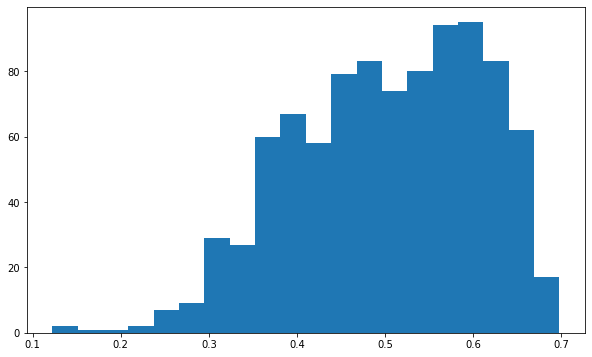

In [14]:
plt.figure(figsize=(10,6))
plt.hist(arys3, bins=20)
plt.show()

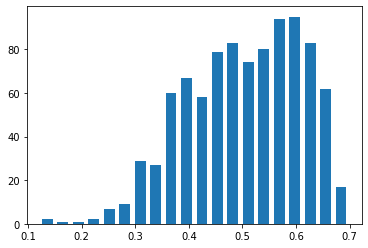

In [18]:
hist, bins = np.histogram(arys3, bins=20)
width = 0.7*(bins[1]-bins[0])
center = (bins[:-1]+bins[1:])/2
plt.bar(center, hist,align='center',width=width)
plt.show()

In [15]:
pdd = pd.DataFrame(arys3)
print(pdd.head(5))
pdd.describe()

          0
0  0.579291
1  0.594027
2  0.641948
3  0.675623
4  0.619248


,0
count,930.000000
mean,0.503186
std,0.105328
min,0.122093
25%,0.424142
50%,0.513803
75%,0.592539
max,0.698259


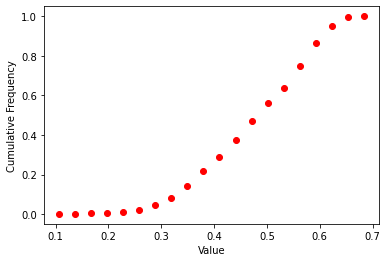

In [16]:
import scipy.stats

# 100 values from a normal distribution with a std of 3 and a mean of 0.5
data = arys3[:,0]
counts, start, dx, _ = scipy.stats.cumfreq(data, numbins=20)
x = np.arange(counts.size) * dx + start
freq = counts/len(arys3[:,0])
plt.plot(x, freq, 'ro')
plt.xlabel('Value')
plt.ylabel('Cumulative Frequency')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


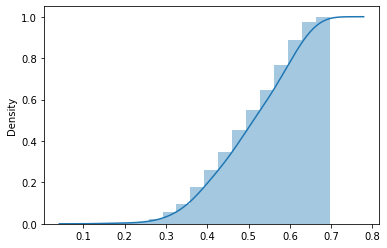

In [17]:
kwargs={'cumulative':True}
sns.distplot(arys3[:,0], hist_kws=kwargs, kde_kws=kwargs)

In [20]:
p = np.array([0.0,2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 90.0, 95.0, 97.5, 100.0])
perc = np.percentile(arys3, p)
perc

array([0.12209332, 0.29815458, 0.31984705, 0.36199221, 0.4241419 ,
       0.51380312, 0.59253889, 0.63406438, 0.652035  , 0.66492261,
       0.69825947])

## Exploring image thresholding

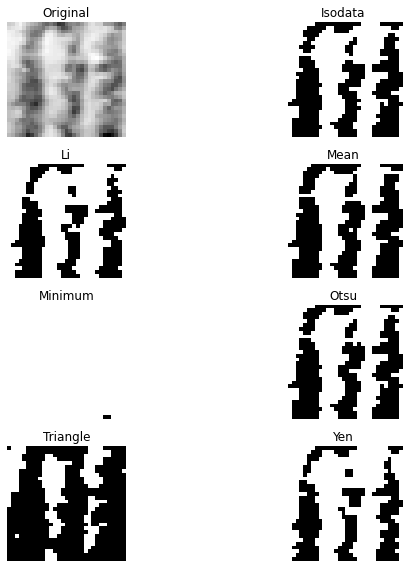

In [21]:
from skimage.filters import try_all_threshold
import skimage.filters as filters

fig, ax = try_all_threshold(arys2.reshape((30,31)), figsize=(10, 8), verbose=False)
plt.show()

In [57]:
lst = ['otsu','li','yen','isodata','mean']

mint= min_threshold(arys2.reshape((30,31)), lst)

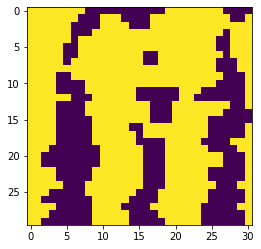

In [58]:
binary = arys2.reshape((30,31)) > mint
plt.imshow(binary)
plt.show()

In [61]:
template = img
ary2tif(binary, img, 'ts.tif')

# Image thresholding

## Define functions

### Image thresholding function

In [34]:
def img_threshold(img, method=None):
  if method=='otsu':
    thre = filters.threshold_otsu(img)
  if method=='li':
    thre = filters.threshold_li(img)
  if method=='yen':
    thre = filters.threshold_yen(img)
  if method=='isodata':
    thre = filters.threshold_isodata(img)
  if method=='mean':
    thre = filters.threshold_mean(img)
    
  return(thre)

### Get minimum threshold

In [35]:
def min_threshold(img, method_list):
  thre = []
  for method in lst:
    thre.append(img_threshold(img, method))

  return(min(thre))

### Image array to geotiff

In [60]:
def ary2tif(img, img_template, nm):
  img = img.astype('float32')
  meta = img_template.meta.copy()
  #meta.update({'nodata': 999, 'dtype': 'float32', 'count':1})


  with rio.open(nm, 'w', **meta) as outf:
    outf.write(img, 1)

### Geotiff to numpy array

In [79]:
def tif2ary(tif):

  raA = rio.open(tif)
  arys = raA.read()

  arys= arys.astype('float32')
  arys =np.moveaxis(arys, 0, -1)

  return(arys)

### Get image statistic for unmask region

In [215]:
def img_stats(img_mlp, vi):

  vi_ary = tif2ary(vi)
  threshold = img_threshold(vi_ary, 'otsu')
  img_binary = vi_ary < threshold 
  img_binary = img_binary.reshape((img_binary.shape[0], img_binary.shape[1]))

  img_ary = tif2ary(img_mlp)
  img_ary[img_binary] = np.nan

  img_ary2 = np.concatenate(img_ary,0)
  
 
  fea_ls = []

  for i in range(img_ary2.shape[1]):
    
    des = describe(img_ary2[:,i], axis=0, nan_policy= 'omit')

    mean = des.mean
    var = des.variance

    fea_ls.append(mean)
    fea_ls.append(var)
  
  return(fea_ls)

# Extract mean and variance for each band 

In [189]:
os.getcwd()

'/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45'

In [72]:
os.chdir('/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45')

In [190]:
tifs = glob.glob("*.tif")
print(("Number of tifs is {}".format(len(tifs))))
tifs[:5]

Number of tifs is 960


['WSR200_2_DH058_50S_ply1_45.tif',
 'WSR200_2_DH072_30MR_ply7_45.tif',
 'WSR200_2_ROB_25MSS_ply5_45.tif',
 'WSR200_2_DH025_5RMR_ply6_45.tif',
 'WSR200_2_DH121_25MSS_ply3_45.tif']

In [192]:
vis = glob.glob("./MCARI2/*.tif")
print("Number of VI is {}".format(len(vis)))
vis[:10]

Number of VI is 960


['./MCARI2/WSR200_2_DH058_50S_ply1_45.tif',
 './MCARI2/WSR200_2_Faller_5RMR_ply2_45.tif',
 './MCARI2/WSR200_2_DH121_25MSS_ply3_45.tif',
 './MCARI2/WSR200_2_DH025_5RMR_ply6_45.tif',
 './MCARI2/WSR200_2_DH80_40MSS_ply4_45.tif',
 './MCARI2/WSR200_2_DH153_5R_ply8_45.tif',
 './MCARI2/WSR200_2_ROB_25MSS_ply5_45.tif',
 './MCARI2/WSR200_2_DH072_30MR_ply7_45.tif',
 './MCARI2/WSR200_2_DH035_10RMR_ply29_45.tif',
 './MCARI2/WSR200_2_DH158_30MRMSS_ply28_45.tif']

In [243]:
fea = None

for i in range(len(tifs)):

  mlp = tifs[i]
  vi = './MCARI2/' + mlp

  dt = img_stats(mlp, vi)
  dt = np.asarray(dt)
  dt = dt.reshape((16,-1))

  if fea is None:
    fea = dt
  else:
    fea = np.concatenate((fea, dt),axis=1)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [244]:
fea.shape

(16, 960)

In [245]:
fea2 = np.transpose(fea)
fea2.shape

(960, 16)

In [247]:
fea_df = pd.DataFrame(fea2)
print(fea_df.shape)
fea_df.head

(960, 16)


<bound method NDFrame.head of                0             1   ...            14            15
0    26054.194118  5.286662e+07  ...  27501.674510  7.538423e+07
1    17164.944186  2.048012e+07  ...  22802.964341  4.913321e+07
2    22268.819835  3.282777e+07  ...  26259.219835  5.153549e+07
3    16797.332787  1.262692e+07  ...  24118.780328  3.323129e+07
4    22230.056058  2.687336e+07  ...  27098.238698  5.203973e+07
..            ...           ...  ...           ...           ...
955  10160.210606  4.188669e+06  ...  12517.398485  6.570395e+06
956   8120.776087  3.139614e+06  ...  13649.269565  9.698606e+06
957  11286.885113  5.842980e+06  ...  13074.679612  1.007164e+07
958   7776.391705  1.491515e+06  ...  11865.756528  4.035828e+06
959  10064.646077  3.514099e+06  ...  13170.641068  8.230420e+06

[960 rows x 16 columns]>

# Get image ID

In [248]:
tifs[:10]

['WSR200_2_DH058_50S_ply1_45.tif',
 'WSR200_2_DH072_30MR_ply7_45.tif',
 'WSR200_2_ROB_25MSS_ply5_45.tif',
 'WSR200_2_DH025_5RMR_ply6_45.tif',
 'WSR200_2_DH121_25MSS_ply3_45.tif',
 'WSR200_2_DH153_5R_ply8_45.tif',
 'WSR200_2_Faller_5RMR_ply2_45.tif',
 'WSR200_2_DH80_40MSS_ply4_45.tif',
 'WSR200_2_DH062_10RMR_ply13_45.tif',
 'WSR200_2_Robin_10R_ply21_45.tif']

In [ ]:
nms=[]

[nms.append(txt.split("_")[4]) for txt in tifs]

In [258]:
print(len(nms))
nms[:5]

960


['ply1', 'ply7', 'ply5', 'ply6', 'ply3']

In [260]:
nms2 = np.asarray(nms)
nms2 = nms2.reshape((len(nms),-1))
nms_df = pd.DataFrame(nms2)
print(nms2.shape)
print(nms_df.shape)

(960, 1)
(960, 1)


In [261]:
fea_df['ply_ID']=nms_df

In [263]:
fea_df.shape

(960, 17)

# Write data

In [265]:
fea_df.to_csv("/BandStats.csv", index=False)